In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.under_sampling import RandomUnderSampler
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv


In [2]:
# CSV dosyasını yükleme ve random 50.000 satır alma
df = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')
df = df.sample(n=50000, random_state=10) 

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1357114,138,CASH_OUT,157548.74,C1622644134,41.00,0.00,C1410204448,0.00,157548.74,0,0
1741821,161,PAYMENT,612.36,C713507882,0.00,0.00,M750820911,0.00,0.00,0,0
5332908,374,CASH_IN,32010.44,C1162363812,3950563.78,3982574.22,C922502124,7560073.53,7528063.10,0,0
5398911,377,PAYMENT,15188.34,C742469163,922.00,0.00,M1218715527,0.00,0.00,0,0
5223348,370,PAYMENT,9771.36,C11682420,10223.34,451.98,M2028882426,0.00,0.00,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1357114 to 129537
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.6+ MB


In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.000000,50000.000000
mean,243.716220,1.793236e+05,8.168195e+05,8.366281e+05,1.110660e+06,1.232987e+06,0.001640,0.000020
std,142.811639,5.220018e+05,2.855714e+06,2.889256e+06,3.077937e+06,3.265901e+06,0.040464,0.004472
min,1.000000,1.030000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,155.000000,1.363699e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,239.000000,7.569449e+04,1.259800e+04,0.000000e+00,1.352645e+05,2.193770e+05,0.000000,0.000000
75%,335.000000,2.088721e+05,1.050604e+05,1.367538e+05,9.502023e+05,1.122530e+06,0.000000,0.000000
max,741.000000,2.578653e+07,3.307841e+07,3.313302e+07,1.169791e+08,1.336039e+08,1.000000,1.000000


In [6]:
#gereksiz kolonları atma ve kategorik değerleri sayısal hale dönüştürme
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

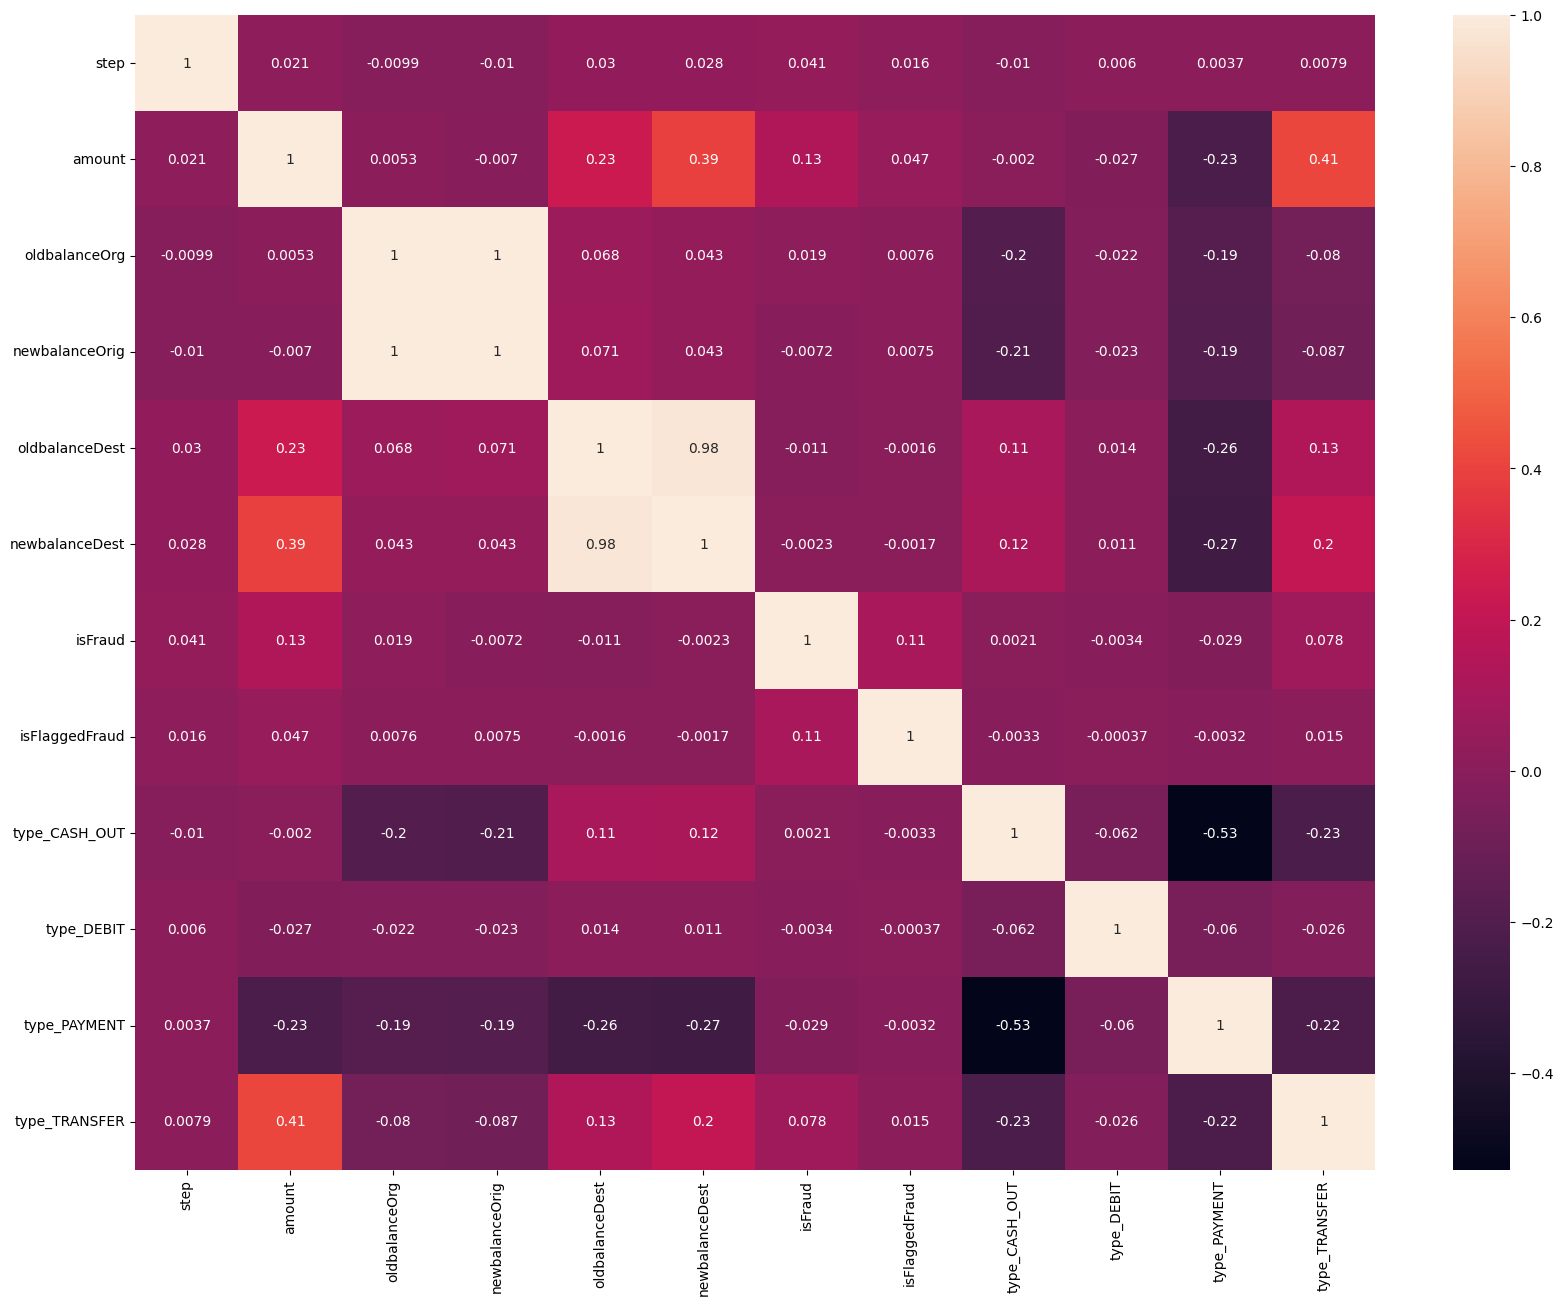

In [7]:
corr_matrix = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [8]:
cor_target = abs(corr_matrix["isFraud"])
relevant_features = cor_target[cor_target>0.03]
relevant_features

step              0.040900
amount            0.132441
isFraud           1.000000
isFlaggedFraud    0.110342
type_TRANSFER     0.077901
Name: isFraud, dtype: float64

In [9]:
to_drop = cor_target[cor_target<0.03]
to_drop

oldbalanceOrg     0.018750
newbalanceOrig    0.007219
oldbalanceDest    0.010523
newbalanceDest    0.002298
type_CASH_OUT     0.002135
type_DEBIT        0.003393
type_PAYMENT      0.028983
Name: isFraud, dtype: float64

In [10]:
type(to_drop)

pandas.core.series.Series

In [11]:
to_drop_frame = to_drop.to_frame()

In [12]:
row_names = to_drop_frame.index
row_names_list = list(row_names)
row_names_list.append('isFraud')
y = df['isFraud'].values
X = df.drop(row_names_list, axis=1).values

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
steps = [('scaler', StandardScaler()),
('dec_tree', DecisionTreeClassifier())]
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)


In [14]:
# SMOTE uygulaması
smote = SMOTE(sampling_strategy=0.2, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Pipeline ve Grid Search
steps = [('scaler', StandardScaler()), ('dec_tree', DecisionTreeClassifier())]
pipeline = Pipeline(steps)

params = {
    "dec_tree__criterion": ['gini', 'entropy'],
    "dec_tree__max_depth": np.arange(3, 15)
}

from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=14, class_weight='balanced')

NameError: name 'SMOTE' is not defined

In [ ]:
# GridSearchCV ile en iyi parametreleri bulma
cv_grid = GridSearchCV(pipeline, param_grid=params, cv=6)
cv_grid.fit(X_train_smote, y_train_smote)

# Test verisinde değerlendirme
y_pred = cv_grid.predict(X_test)

# Sonuçların raporlanması
print(classification_report(y_test, y_pred))
print("En iyi parametreler: ", cv_grid.best_params_)